# Oracle Consensus Algorithms

In [3]:
import numpy as np
from typing import List, Tuple
import seaborn as sns
import matplotlib.pyplot as plt

## Sample Data

In [60]:
N_oracles = 20
failing_percentage = 0.2
N_failing_oracles = round(N_oracles * failing_percentage)


In [72]:
def normalize(x) :
    return (np.arctan(x) / np.pi) + 0.5

def denormalize(y) :
    return np.tan(np.pi * (y - 0.5))

def generate_oracles(N_oracles, N_failing_oracles, e=0, sigma=1):
    oracles = [
        (normalize(np.random.normal(denormalize(e), sigma)), True)
        if i >= N_failing_oracles 
        else (np.random.uniform(0, 1), False)
        for i in range(N_oracles)
    ]

    np.random.shuffle(oracles)

    disjoint = tuple_listes = tuple(map(list, zip(*oracles)))

    return disjoint

true_essence = 0.9
true_sigma = 5

oracles, true_oracles = generate_oracles(N_oracles, N_failing_oracles, true_essence, true_sigma)

#### Typical data

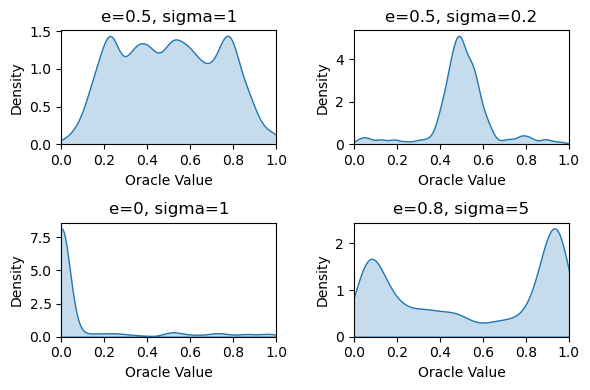

In [73]:
def plot_oracles_density(N_oracles, N_failing_oracles, e1, e2, e3, e4, sigma1, sigma2, sigma3, sigma4):
    # Generate oracles for each combination of true essence and true sigma
    oracles_sets = [
        generate_oracles(N_oracles, N_failing_oracles, e1, sigma1),
        generate_oracles(N_oracles, N_failing_oracles, e2, sigma2),
        generate_oracles(N_oracles, N_failing_oracles, e3, sigma3),
        generate_oracles(N_oracles, N_failing_oracles, e4, sigma4)
    ]

    # Set up the matplotlib figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))
    axes = axes.flatten()

    # Titles for each subplot
    titles = [
        f'e={e1}, sigma={sigma1}',
        f'e={e2}, sigma={sigma2}',
        f'e={e3}, sigma={sigma3}',
        f'e={e4}, sigma={sigma4}'
    ]

    # Plot each oracle set
    for i, (oracles, true_oracles) in enumerate(oracles_sets):
        oracle_values = np.array(oracles)
        sns.kdeplot(oracle_values, bw_adjust=0.5, fill=True, ax=axes[i])
        axes[i].set_xlim(0, 1)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Oracle Value')
        axes[i].set_ylabel('Density')

    plt.tight_layout()
    plt.show()

e1, e2, e3, e4 = 0.5, 0.5, 0, 0.8
sigma1, sigma2, sigma3, sigma4 = 1, 0.2, 1, 5
plot_oracles_density(300, 60, e1, e2, e3, e4, sigma1, sigma2, sigma3, sigma4)


#### Current sample density

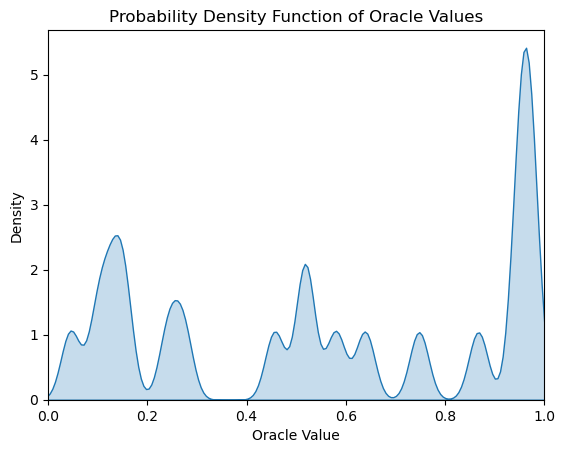

In [80]:
def plot():
    oracle_values = np.array(oracles)

    sns.kdeplot(oracle_values, bw_adjust=0.1, fill=True)
    plt.xlim(0, 1)
    plt.title('Probability Density Function of Oracle Values')
    plt.xlabel('Oracle Value')
    plt.ylabel('Density')
    plt.show()

plot()

## Simple Algorithm

In [75]:
def essence_estimate(oracles : List[Tuple[float, bool]]):
    '''
        By default, average
    '''

    weight = 0
    result = 0

    for value, activated in oracles:
        if activated :
            weight += 1
            result += value
    
    return result / weight


def one_oracle_score(oracle_value, essence_estimate):
    '''
        Let's say the oracle score is defined by the squared euclidean distance to the essence estimate
    '''
    return np.linalg.norm(oracle_value - essence_estimate) ** 2


def compute_scores(oracles : List[Tuple[float, bool]], only_active : bool = False) :
    essence = essence_estimate(oracles)
    return [
        one_oracle_score(value, essence)
        if activated or not only_active else None
        for value, activated in oracles
    ]

def argmin(T):
    min_value = None 
    min_idx = None
    for idx, value in enumerate(T):
        if value is None : continue

        if min_value is None :
            min_value = value
            min_idx = idx
            continue

        if value < min_value :
            min_value = value
            min_idx = idx

    return min_idx

def find_the_worst_oracle(oracles : List[Tuple[float, bool]]) :
    return argmin(compute_scores(oracles, True))

def remove_worst_oracles(oracles : List[float], N_failing_oracles : int) :
    result = [(oracle, True) for oracle in oracles]

    for _ in range(N_failing_oracles):
        worst = find_the_worst_oracle(result) 
        result[worst] = (result[worst][0], False)

    return result, compute_scores(result)

result, scores = remove_worst_oracles(oracles, N_failing_oracles)

In [76]:
for i in range(len(result)) :
    expected = true_oracles[i]
    found = result[i][1]
    s = "[ ]" if expected == found else "[X]"

    print(f"- {s}\t Expected : {expected} \t Found : {found} \t Score : {scores[i]}")

- [X]	 Expected : False 	 Found : True 	 Score : 0.15405942559700653
- [ ]	 Expected : True 	 Found : True 	 Score : 0.17387778542095214
- [ ]	 Expected : True 	 Found : True 	 Score : 0.16276654286884856
- [ ]	 Expected : True 	 Found : True 	 Score : 0.17136217745694418
- [ ]	 Expected : True 	 Found : True 	 Score : 0.1601171075410883
- [ ]	 Expected : True 	 Found : True 	 Score : 0.19125477279055844
- [X]	 Expected : True 	 Found : False 	 Score : 0.006682780063550596
- [ ]	 Expected : False 	 Found : False 	 Score : 0.0014959127443748665
- [ ]	 Expected : True 	 Found : True 	 Score : 0.15346905404254504
- [ ]	 Expected : True 	 Found : True 	 Score : 0.1720382171630445
- [ ]	 Expected : True 	 Found : True 	 Score : 0.09602386003899044
- [ ]	 Expected : True 	 Found : True 	 Score : 0.21105237771372812
- [ ]	 Expected : True 	 Found : True 	 Score : 0.0992102851259711
- [X]	 Expected : False 	 Found : True 	 Score : 0.08127865395917858
- [X]	 Expected : True 	 Found : False 	 Sc

In [79]:
normalized_error = np.abs(essence_estimate(result) - true_essence) 
denormalized_error = np.abs(denormalize(essence_estimate(result)) - denormalize(true_essence))

print(f"normalized error: {normalized_error}")
print(f"denormalized error: {denormalized_error}")

normalized error: 0.34275350054497844
denormalized error: 2.895873947968922


The first method is clearly not effective.
Possibles issues :
- Current essence estimate would work for a gaussian noise but not for the normalized gaussian. 